# Learning about RNN, GRU, LSTM models

Using tensorflow's keras within my `ml-tensorflow-wsl` env.  Most of the code (and this table) comes from [ChatGPT](https://chatgpt.com/share/6761996f-b804-8008-a89d-7ed51793e5e4).

| Feature                      | **RNN**                 | **LSTM**                          | **GRU**                           |
|------------------------------|-------------------------|-----------------------------------|----------------------------------|
| **Gates**                   | None                   | Input, Forget, Output             | Update, Reset                    |
| **Long-term Dependencies**   | Struggles (vanishing gradients) | Handles effectively              | Handles effectively              |
| **Complexity**               | Low (simple architecture) | High (more gates, slower)        | Medium (simpler than LSTM)       |
| **Training Time**            | Fast                   | Slower                           | Faster than LSTM                 |
| **Memory Usage**             | Low                    | High                             | Lower than LSTM                  |
| **Performance**              | Poor for long sequences | Excellent for long sequences     | Similar to LSTM, often faster    |
| **Use Cases**                | Short sequences         | Text, speech, long sequences     | Similar to LSTM, faster training |


In [7]:
#import numpy as np
#import pandas as pd
#import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, LSTM, GRU
# from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt


Using the IMDB movie reviews dataset for simplicity. Keras provides this dataset directly.

- X_train and X_test contain tokenized movie reviews (each word replaced by an integer ID).
- y_train and y_test are sentiment labels (0 for negative, 1 for positive).


In [2]:
# Load IMDB dataset
from tensorflow.keras.datasets import imdb

vocab_size = 10000  # Number of most frequent words to use
max_length = 100    # Max length of each input sequence (padded or truncated)
index_from = 3      # word index offset


# Load IMDB dataset
(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=vocab_size, index_from=index_from)

# Pad sequences to ensure uniform input size
X_train = pad_sequences(X_train, maxlen=max_length, padding='post', truncating='post')
X_test = pad_sequences(X_test, maxlen=max_length, padding='post', truncating='post')

print(f"Training data shape: {X_train.shape}, Labels shape: {y_train.shape}")

Training data shape: (25000, 100), Labels shape: (25000,)


In [3]:
X_train[0]

array([   1,   14,   22,   16,   43,  530,  973, 1622, 1385,   65,  458,
       4468,   66, 3941,    4,  173,   36,  256,    5,   25,  100,   43,
        838,  112,   50,  670,    2,    9,   35,  480,  284,    5,  150,
          4,  172,  112,  167,    2,  336,  385,   39,    4,  172, 4536,
       1111,   17,  546,   38,   13,  447,    4,  192,   50,   16,    6,
        147, 2025,   19,   14,   22,    4, 1920, 4613,  469,    4,   22,
         71,   87,   12,   16,   43,  530,   38,   76,   15,   13, 1247,
          4,   22,   17,  515,   17,   12,   16,  626,   18,    2,    5,
         62,  386,   12,    8,  316,    8,  106,    5,    4, 2223, 5244,
         16], dtype=int32)

Also get the actual data so that I can compare to the real reviews.  (Note that ChatGPT forgot about the "index_from" parameter, here and above.  I found that on Stack Overflow [here](https://stackoverflow.com/questions/42821330/restore-original-text-from-keras-s-imdb-dataset).)

In [4]:
# Load the word index for IMDB dataset
word_index = imdb.get_word_index()

# Reverse the word index to get an index-to-word mapping
reverse_word_index = {(value + index_from) : key for (key, value) in word_index.items()}

# Special tokens in the dataset
reverse_word_index[0] = "<PAD>"   # Padding token
reverse_word_index[1] = "<START>" # Start token
reverse_word_index[2] = "<UNK>"   # Unknown token
reverse_word_index[3] = "<UNUSED>"

def decode_review(encoded_review):
    """
    Convert a tokenized review back to text.
    """
    return " ".join([reverse_word_index[id] for id in encoded_review ])


In [5]:
# Example: Decode a training review
index = 0
sample_review = X_train[index]  # First tokenized review
print("Decoded Review:")
print(decode_review(sample_review))

# Display the corresponding label
print("\nSentiment Label:", "Positive" if y_train[index] == 1 else "Negative")


Decoded Review:
<START> this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert <UNK> is an amazing actor and now the same being director <UNK> father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for <UNK> and would recommend it to everyone to watch and the fly fishing was

Sentiment Label: Positive


## Build the RNN model

- Embedding: Converts integer word indices to dense word vectors.
- SimpleRNN: Processes the sequence of word embeddings.
- Dense: Outputs a single value (0 or 1) using the sigmoid activation for binary classification.

In [8]:
# RNN Model for Sentiment Analysis
embedding_dim = 32  # Size of word embedding vectors

model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length),
    SimpleRNN(64, return_sequences=False),  # RNN layer with 64 units
    Dense(1, activation='sigmoid')          # Output layer for binary classification
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Model summary
model.summary()

/home/ageller/miniforge3/envs/ml-tensorflow-wsl/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
I0000 00:00:1734456779.307513   24281 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5520 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4070 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn (SimpleRNN)          │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Train the model

(some notes on the batch size and epochs from ChatGPT)

| Hyperparameter | Small Value| Large Value |
| -------------- | ---------- | ----------- |
| Batch Size     | Noisy updates, slower training, better generalization | Smooth updates, faster training, risk of poor generalization |
| Epochs         | Underfitting (not enough training) | Overfitting (training too long) |

In [9]:
# Train the model
batch_size = 64
epochs = 5

history = model.fit(X_train, y_train, 
                    validation_data=(X_test, y_test), 
                    batch_size=batch_size, 
                    epochs=epochs)

Epoch 1/5


I0000 00:00:1734456782.974306   24615 service.cc:148] XLA service 0x7faa18015780 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1734456782.974422   24615 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 4070 Laptop GPU, Compute Capability 8.9
2024-12-17 11:33:03.029265: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1734456783.300863   24615 cuda_dnn.cc:529] Loaded cuDNN version 90300


  1/391 ━━━━━━━━━━━━━━━━━━━━ 23:11 4s/step - accuracy: 0.5781 - loss: 0.6802

I0000 00:00:1734456784.319691   24615 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


391/391 ━━━━━━━━━━━━━━━━━━━━ 20s 42ms/step - accuracy: 0.5049 - loss: 0.6958 - val_accuracy: 0.5121 - val_loss: 0.6944
Epoch 2/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 11s 27ms/step - accuracy: 0.6316 - loss: 0.6500 - val_accuracy: 0.5042 - val_loss: 0.8607
Epoch 3/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - accuracy: 0.6638 - loss: 0.6175 - val_accuracy: 0.5682 - val_loss: 0.7367
Epoch 4/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 13s 34ms/step - accuracy: 0.8055 - loss: 0.4207 - val_accuracy: 0.6572 - val_loss: 0.6919
Epoch 5/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - accuracy: 0.9046 - loss: 0.2285 - val_accuracy: 0.6278 - val_loss: 0.8898


Evaluate the model 

In [10]:
# Evaluate on test data (this is actually printed about above, so not really necessary to run here)
# loss, accuracy = model.evaluate(X_test, y_test)
# print(f"Test Accuracy: {accuracy * 100:.2f}%")


In [11]:
def make_plots(history):
    # plot the loss and accuracy curves
    f, ax = plt.subplots(1, 2, figsize=(12,5))

    ax[0].plot(history.history['loss'], label = 'training')
    ax[0].plot(history.history['val_loss'], label = 'validation')
    ax[0].set_yscale('log')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Loss')
    ax[0].legend()

    ax[1].plot(history.history['accuracy'], label = 'training')
    ax[1].plot(history.history['val_accuracy'], label = 'validation')
    ax[1].set_yscale('log')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Accuracy')
    ax[1].legend()

    plt.subplots_adjust(wspace=0.3)

    return f, ax

(<Figure size 1200x500 with 2 Axes>,
 array([<Axes: xlabel='Epoch', ylabel='Loss'>,
        <Axes: xlabel='Epoch', ylabel='Accuracy'>], dtype=object))

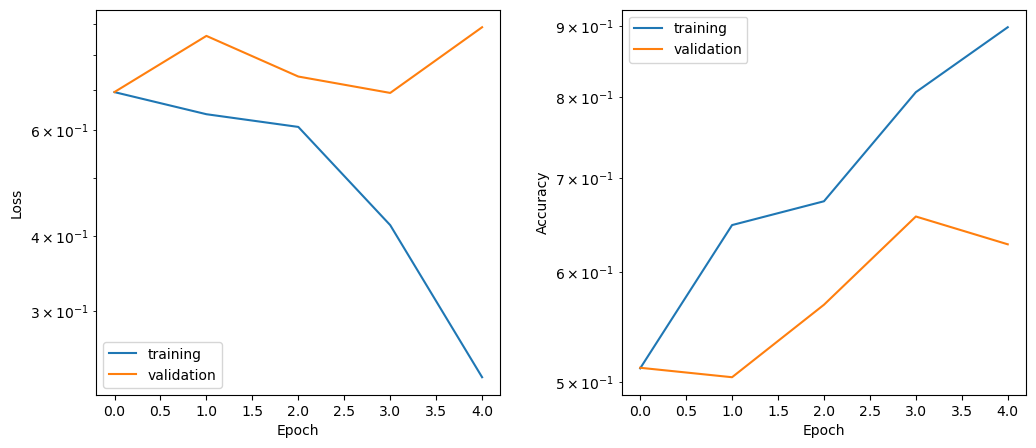

In [12]:
make_plots(history)

Make predictions

In [13]:
# Predict sentiment for a few test samples
predictions = (model.predict(X_test) > 0.5).astype("int32")

# Compare with actual labels
print(f"First 10 predictions: {predictions[:10].ravel()}")
print(f"Actual labels: {y_test[:10]}")

782/782 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step
First 10 predictions: [1 1 1 0 1 0 0 1 1 1]
Actual labels: [0 1 1 0 1 1 1 0 0 1]


In [14]:
index_test = 0
print(y_test[index_test],predictions[index_test])
print(decode_review(X_test[index_test]))


0 [1]
<START> please give this one a miss br br <UNK> <UNK> and the rest of the cast rendered terrible performances the show is flat flat flat br br i don't know how michael madison could have allowed this one on his plate he almost seemed to know this wasn't going to work out and his performance was quite <UNK> so all you madison fans give this a miss <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>


## Try LSTM

In [15]:
model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length),
    LSTM(64, return_sequences=False),  # LSTM layer
    Dense(1, activation='sigmoid')     # Output layer
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Model summary
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [16]:
history = model.fit(X_train, y_train, 
                    validation_data=(X_test, y_test), 
                    batch_size=batch_size, 
                    epochs=epochs)

Epoch 1/5


391/391 ━━━━━━━━━━━━━━━━━━━━ 21s 45ms/step - accuracy: 0.6225 - loss: 0.6115 - val_accuracy: 0.8041 - val_loss: 0.4332
Epoch 2/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 24s 61ms/step - accuracy: 0.8644 - loss: 0.3348 - val_accuracy: 0.8134 - val_loss: 0.4277
Epoch 3/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 25s 65ms/step - accuracy: 0.8724 - loss: 0.3209 - val_accuracy: 0.7746 - val_loss: 0.8054
Epoch 4/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 26s 66ms/step - accuracy: 0.5737 - loss: 0.8098 - val_accuracy: 0.5604 - val_loss: 0.6758
Epoch 5/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 28s 70ms/step - accuracy: 0.7202 - loss: 0.5502 - val_accuracy: 0.7941 - val_loss: 0.4673


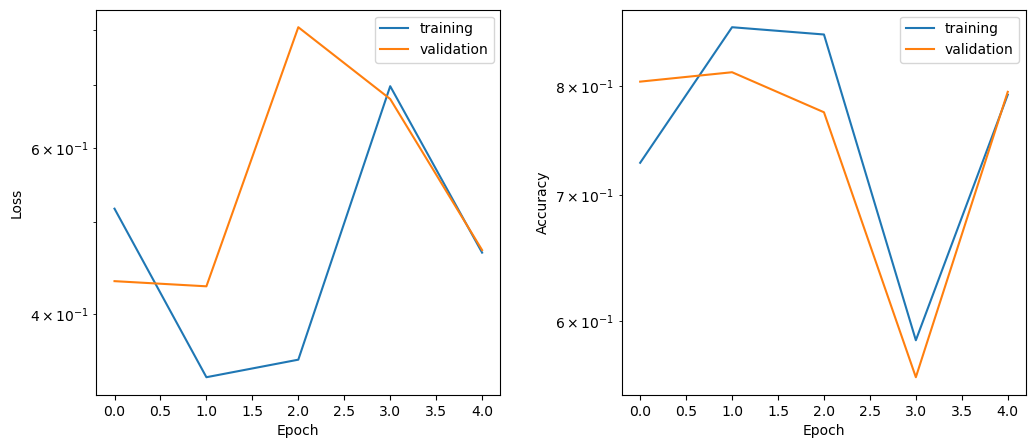

In [17]:
f,ax = make_plots(history)

In [18]:
# Predict sentiment for a few test samples
predictions = (model.predict(X_test) > 0.5).astype("int32")

# Compare with actual labels
print(f"First 10 predictions: {predictions[:10].ravel()}")
print(f"Actual labels: {y_test[:10]}")

782/782 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step
First 10 predictions: [0 1 1 0 1 0 0 1 1 0]
Actual labels: [0 1 1 0 1 1 1 0 0 1]


In [19]:
index_test = 5
print(y_test[index_test],predictions[index_test])
print(decode_review(X_test[index_test]))

1 [0]
<START> i'm absolutely disgusted this movie isn't being sold all who love this movie should email disney and increase the demand for it they'd eventually have to sell it then i'd buy copies for everybody i know everything and everybody in this movie did a good job and i haven't figured out why disney hasn't put this movie on dvd or on vhs in rental stores at least i haven't seen any copies this is a wicked good movie and should be seen by all the kids in the new generation don't get to see it and i think they


## Try GRU

In [20]:
model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length),
    GRU(64, return_sequences=False),   # GRU layer
    Dense(1, activation='sigmoid')     # Output layer
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Model summary
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [21]:
history = model.fit(X_train, y_train, 
                    validation_data=(X_test, y_test), 
                    batch_size=batch_size, 
                    epochs=epochs)

Epoch 1/5


391/391 ━━━━━━━━━━━━━━━━━━━━ 31s 71ms/step - accuracy: 0.5715 - loss: 0.6522 - val_accuracy: 0.7922 - val_loss: 0.4642
Epoch 2/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step - accuracy: 0.8513 - loss: 0.3670 - val_accuracy: 0.8088 - val_loss: 0.4230
Epoch 3/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - accuracy: 0.8998 - loss: 0.2633 - val_accuracy: 0.8194 - val_loss: 0.4387
Epoch 4/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - accuracy: 0.9257 - loss: 0.2072 - val_accuracy: 0.8096 - val_loss: 0.4799
Epoch 5/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 0.9515 - loss: 0.1429 - val_accuracy: 0.8016 - val_loss: 0.5122


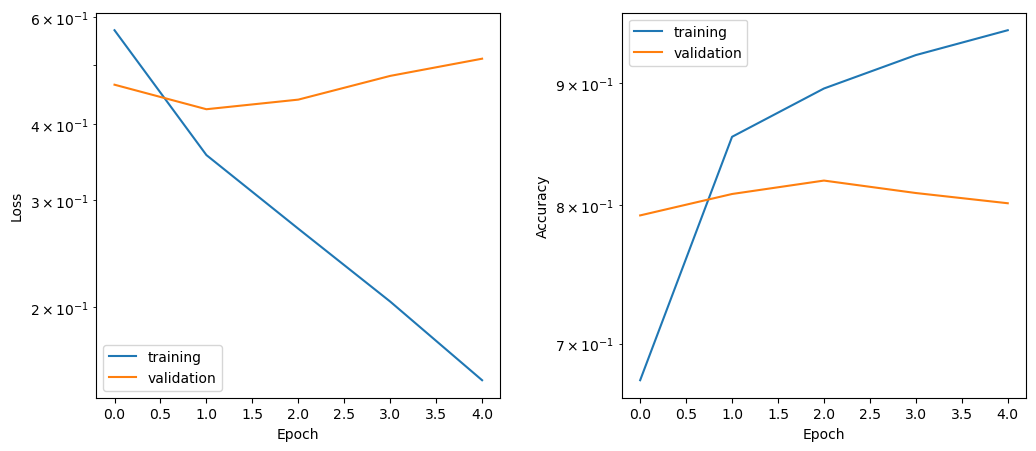

In [22]:
f,ax = make_plots(history)

In [23]:
# Predict sentiment for a few test samples
predictions = (model.predict(X_test) > 0.5).astype("int32")
predictions_raw = model.predict(X_test)

# Compare with actual labels
print(f"First 10 raw predictions: {predictions_raw[:10].ravel()}")
print(f"First 10 predictions: {predictions[:10].ravel()}")
print(f"Actual labels: {y_test[:10]}")

782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
First 10 raw predictions: [0.01428703 0.9804331  0.6371505  0.01615412 0.95689833 0.07762287
 0.72925866 0.94504887 0.98144734 0.17282753]
First 10 predictions: [0 1 1 0 1 0 1 1 1 0]
Actual labels: [0 1 1 0 1 1 1 0 0 1]


In [24]:
index_test = 9
print(y_test[index_test],predictions[index_test])
print(decode_review(X_test[index_test]))

1 [0]
<START> this film is where the batman franchise ought to have stopped though i will <UNK> that the ideas behind batman forever were excellent and could have been easily realised by a competent director as it turned out this was not to be the case br br apparently warner brothers executives were disappointed with how dark this second batman film from tim burton turned out apart from the idiocy of expecting anything else from burton and the conservative <UNK> of their subsequent decision to turn the franchise into an homage to the sixties tv series i fail to understand how


## Information from ChatGPT on fine tuning RNN/LSTM/GRU models:

**Fine-tuning** in machine learning refers to the process of **adjusting hyperparameters** and model settings to achieve better performance. It is an iterative process where you experiment with various parameters to improve accuracy, generalization, and efficiency.

---

### **Fine-Tuning Parameters in an RNN/GRU/LSTM**

Here are the most common parameters you can adjust for fine-tuning your sequential model:

1. **Batch Size**:
   - Smaller batch sizes (e.g., 16 or 32) result in noisier updates and longer training but can generalize better.
   - Larger batch sizes (e.g., 64 or 128) are computationally faster but may generalize worse.
   - **Experiment**: Try batch sizes of 16, 32, and 64 to see their effects.

2. **Epochs**:
   - Too few epochs: Underfitting.
   - Too many epochs: Overfitting.
   - Use **early stopping** to monitor the validation loss and stop training when it stops improving.
   - **Experiment**: Start with 10-20 epochs and monitor performance.

3. **Learning Rate**:
   - Controls the step size during optimization.
   - A learning rate that is **too high** causes the model to overshoot minima, while a rate that is **too low** makes training slow or stuck.
   - Use a **learning rate scheduler** or adjust it manually:
     ```python
     from tensorflow.keras.optimizers import Adam
     optimizer = Adam(learning_rate=0.001)  # Default LR = 0.001
     ```

4. **Optimizer**:
   - Different optimizers affect the convergence of your model. Popular choices include:
     - `Adam` (default for many models) – adaptive and fast.
     - `RMSprop` – often used for RNNs and LSTMs.
     - `SGD` with momentum – slower but can be stable in some cases.
   - **Experiment**: Compare `Adam` and `RMSprop`.

5. **Dropout Rate**:
   - Prevents overfitting by randomly "dropping out" neurons during training.
   - For recurrent models, **recurrent dropout** is also available.
   - **Example**:
     ```python
     from tensorflow.keras.layers import LSTM
     LSTM(128, dropout=0.2, recurrent_dropout=0.2)
     ```
   - **Experiment**: Start with 0.2 and adjust to 0.1–0.5.

6. **Number of Units (Neurons)**:
   - Increasing the number of hidden units in RNN/GRU/LSTM layers allows the model to learn more complex patterns.
   - However, more units increase computation time and the risk of overfitting.
   - **Experiment**: Use 64, 128, or 256 units and evaluate the results.

7. **Layer Depth**:
   - Adding more layers (stacked RNN/GRU/LSTM) can help learn hierarchical patterns but increases the model's complexity.
   - Example:
     ```python
     model.add(LSTM(128, return_sequences=True))  # First LSTM layer
     model.add(LSTM(64))                         # Second LSTM layer
     ```

8. **Sequence Length** (Padding/Trimming):
   - The maximum sequence length affects how much of the input data the model processes.
   - Longer sequences may improve performance but slow down training.
   - **Experiment**: Adjust the sequence length during `pad_sequences`:
     ```python
     from tensorflow.keras.preprocessing.sequence import pad_sequences
     X_train = pad_sequences(X_train, maxlen=200)  # Limit to 200 words
     ```

9. **Regularization**:
   - Add L1/L2 penalties to prevent overfitting.
   - **Example**:
     ```python
     from tensorflow.keras.regularizers import l2
     LSTM(128, kernel_regularizer=l2(0.01))
     ```

10. **Activation Functions**:
    - RNNs/GRUs/LSTMs use `tanh` and `sigmoid` internally, but you can experiment with the activation functions for dense layers:
      ```python
      model.add(Dense(1, activation='sigmoid'))  # Binary classification
      ```

---

### **What to Try for Fine-Tuning?**

Start with the following strategy:

1. **Baseline Model**:
   - Build a simple model using default parameters (e.g., LSTM with 128 units, batch size 32, 10 epochs).
   - Evaluate performance (training/validation accuracy and loss).

2. **Learning Rate Adjustment**:
   - Lower the learning rate (e.g., 0.0005) if the model is not converging.
   - Increase it (e.g., 0.005) if the model is learning too slowly.

3. **Dropout Regularization**:
   - Introduce dropout (e.g., 0.2) to prevent overfitting.

4. **Batch Size Tuning**:
   - Compare results for batch sizes 16, 32, and 64.

5. **Number of Units and Layer Depth**:
   - Increase hidden units (128 → 256) and test adding a second RNN/GRU/LSTM layer.

6. **Early Stopping**:
   - Monitor validation loss to stop training when overfitting begins.

---

### **Code Example for Fine-Tuning**

Here’s an updated model with some fine-tuning parameters:

```python
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Build the model
model = Sequential()
model.add(LSTM(128, return_sequences=True, dropout=0.2, recurrent_dropout=0.2, input_shape=(200, 1)))
model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

# Compile the model with a lower learning rate
optimizer = Adam(learning_rate=0.0005)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Train the model with early stopping
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(X_train, y_train, 
                    validation_data=(X_val, y_val),
                    batch_size=32, 
                    epochs=20, 
                    callbacks=[early_stopping])
```

---

### **Summary Recommendations**:
1. Start with default hyperparameters (e.g., batch size 32, learning rate 0.001, dropout 0.2).
2. Fine-tune by:
   - Adjusting **batch size** and **epochs**.
   - Experimenting with **dropout**, **number of units**, and **learning rate**.
   - Adding **early stopping** to prevent overfitting.
3. Monitor both training and validation loss/accuracy to evaluate your changes.

Fine-tuning is all about experimentation. Change one parameter at a time and observe its effect on performance! 🚀 Let me know if you’d like to analyze model performance metrics further.

# ChatGPT suggestions for measureing confidence or uncertainty

Yes, you can output a measure of **confidence** or **uncertainty** for LSTM, RNN, or GRU models, especially for **classification tasks**. Here’s an overview of approaches to achieve this:

---

### **1. Use Probabilities as Confidence**
If your model uses a **sigmoid activation** (for binary classification) or **softmax activation** (for multi-class classification) in the output layer, the output values can be directly interpreted as probabilities.

- **Sigmoid (Binary Classification)**:
   The output will be between 0 and 1, where:
   - A value close to 1 indicates **high confidence** for class "1."
   - A value close to 0 indicates **high confidence** for class "0."

- **Softmax (Multi-Class Classification)**:
   The output is a probability distribution across all classes. The class with the **highest probability** is the predicted class, and the probability itself can be treated as the confidence score.

**Code Example:**
```python
import numpy as np

# Simulated model predictions (binary classification)
predictions = model.predict(X_test)  # Outputs probabilities between 0 and 1

# Interpret confidence
for i, p in enumerate(predictions[:5]):
    print(f"Sample {i}: Predicted Probability = {p[0]:.4f}, Confidence = {max(p[0], 1-p[0]):.4f}")
```

For **softmax outputs**:
```python
predictions = model.predict(X_test)  # Softmax output
confidence = np.max(predictions, axis=1)  # Confidence for each sample
print("Confidence Scores:", confidence)
```

---

### **2. Monte Carlo Dropout (Bayesian Approximation)**
To estimate **uncertainty** in predictions, you can use **Monte Carlo Dropout**. This involves:
- Applying **dropout** during both training **and inference** (testing).
- Running the model multiple times on the same input and obtaining multiple predictions.
- Computing the **mean** and **standard deviation** of the predictions to measure confidence and uncertainty.

**Key Idea**: If predictions vary a lot (high standard deviation), the model is uncertain.

**Code Example:**
```python
import tensorflow.keras.backend as K
import numpy as np

# Define a function to enable dropout during inference
f_model = K.function([model.input, K.learning_phase()], [model.output])

def monte_carlo_predictions(model, X, num_samples=50):
    preds = np.array([f_model([X, 1])[0] for _ in range(num_samples)])
    return preds.mean(axis=0), preds.std(axis=0)

# Use Monte Carlo dropout for uncertainty estimation
num_samples = 50
mean_preds, uncertainty = monte_carlo_predictions(model, X_test, num_samples)

# Display confidence and uncertainty
for i in range(5):
    print(f"Sample {i}: Prediction Mean = {mean_preds[i][0]:.4f}, Uncertainty = {uncertainty[i][0]:.4f}")
```

- **`mean_preds`**: Average predictions (confidence scores).
- **`uncertainty`**: Standard deviation, which indicates uncertainty.

**When to use**: This method is particularly useful when you suspect the model might encounter **ambiguous inputs**.

---

### **3. Temperature Scaling**
**Temperature scaling** is a post-training calibration method to adjust the probabilities predicted by a model. It modifies the softmax probabilities to make them more reflective of confidence.

The temperature-scaled softmax is defined as:
\[
p_i = \frac{\exp(z_i / T)}{\sum_j \exp(z_j / T)}
\]
Where:
- \( z_i \) = logits (raw predictions before softmax).
- \( T \) = temperature (default is 1). Higher \( T \) makes probabilities smoother, reducing confidence scores.

**Code Example:**
```python
import numpy as np
import tensorflow as tf

def temperature_scale(logits, temperature=2.0):
    logits_scaled = logits / temperature
    return tf.nn.softmax(logits_scaled).numpy()

# Example predictions (logits before softmax)
logits = np.array([[3.2, 1.5, 0.2]])  # Raw model outputs

# Apply temperature scaling
temperature = 2.0
confidences = temperature_scale(logits, temperature)
print("Softmax probabilities after temperature scaling:", confidences)
```

- **Higher Temperature**: Makes predictions more uncertain (reduces confidence).
- **Lower Temperature**: Increases confidence.

---

### **4. Entropy-Based Confidence**
You can compute the **entropy** of the softmax output to measure uncertainty. Entropy quantifies the "spread" of probabilities:
- **Low entropy** → Probabilities are concentrated (high confidence).
- **High entropy** → Probabilities are spread out (low confidence).

For a probability vector \( p \), the entropy is:
\[
H(p) = -\sum_{i} p_i \log(p_i)
\]

**Code Example**:
```python
from scipy.stats import entropy

# Softmax probabilities from the model
predictions = model.predict(X_test)

# Calculate entropy for each sample
entropies = [entropy(pred) for pred in predictions]

# Output entropy as a measure of uncertainty
for i, e in enumerate(entropies[:5]):
    print(f"Sample {i}: Entropy = {e:.4f}")
```

- High entropy indicates **uncertainty**.
- Low entropy indicates **confidence**.

---

### **5. Confidence via Model Calibration**
Sometimes, models tend to **overconfidently predict probabilities**. You can evaluate the reliability of the confidence scores through **calibration techniques** such as:
- **Reliability Diagrams**.
- **Expected Calibration Error (ECE)**.
Tools like **`temperature scaling`** and **`Platt scaling`** are commonly used to calibrate predictions.

---

### **Summary of Approaches**
| **Method**                          | **Description**                                | **Measure**            |
|-------------------------------------|----------------------------------------------|------------------------|
| **Raw Probabilities**               | Use softmax/sigmoid outputs as confidence.    | Probability value      |
| **Monte Carlo Dropout**             | Perform stochastic inference with dropout.    | Mean + Standard Dev.   |
| **Temperature Scaling**             | Smooth probabilities using a temperature.     | Adjusted softmax values|
| **Entropy-Based Confidence**        | Calculate entropy of softmax outputs.         | Entropy (lower = confident) |
| **Calibration Techniques**          | Adjust predictions to reflect true confidence.| Reliability diagrams   |

---

### **Recommendation for Your Project**
1. Start with **raw probabilities** to interpret confidence scores.
2. Implement **Monte Carlo Dropout** for uncertainty estimation if you want a deeper analysis.
3. Use **entropy-based confidence** to quantify how "confident" the softmax probabilities are.

Combining these techniques can give you a comprehensive understanding of your model's predictions and its uncertainty. Let me know if you'd like a deeper dive into any specific method! 🚀